# ATAC-Seq Analysis for HNSC_Omics_Database

This notebook serves as a preliminary exploration and analysis of **Assay for Transposase-Accessible Chromatin using Sequencing (ATAC-Seq)** data. The goal is to generate data that can later be integrated into the **HNSC_Omics_Database**, which focuses on the tumor microenvironment in **Head and Neck Squamous Cell Carcinoma (HNSC)**. Through this pipeline, we aim to identify accessible chromatin regions across the genome, providing insights into regulatory elements like enhancers and promoters that are relevant for understanding cancer biology.

### Objectives
In this notebook, we will:
1. Perform quality control checks on ATAC-Seq reads.
2. Align reads to the reference genome.
3. Identify peaks (open chromatin regions).
4. Annotate peaks with relevant genomic features.
5. Format and prepare data for integration into the HNSC_Omics_Database.

Each step includes visualizations to interpret the data quality and structure.

---

## 1. Quality Control (QC) of ATAC-Seq Data

Quality control is essential in sequencing data analysis to ensure high-quality reads, which directly impacts the reliability of downstream results. Here, we will use **FastQC** for individual read quality checks and **MultiQC** to compile these reports for all samples.

#### Quality Control Steps
1. Run FastQC on each sample’s FASTQ file.
2. Use MultiQC to aggregate and visualize QC metrics.

### Step 1.1: Load Required Libraries and Set Up Environment
To begin, we need to load essential libraries and set up paths for our raw data and output directories.


In [1]:
# Install required packages if not already installed
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}
BiocManager::install(c("GEOquery", "rtracklayer", "GenomicRanges"))

# Load necessary libraries
library(GEOquery) # To access and parse GEO data
library(ggplot2) # For data visualization
library(dplyr) # For data manipulation
library(GenomicRanges) # For working with genomic ranges

# Set the GEO dataset ID for the ATAC-Seq data we want to explore
gse_id <- "GSE135604"

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'GEOquery' 'GenomicRanges'"
Installing package(s) 'rtracklayer'

also installing the dependencies 'lambda.r', 'futile.options', 'futile.logger', 'snow', 'BH', 'bitops', 'BiocParallel', 'Rhtslib', 'RCurl', 'rjson', 'Rsamtools', 'GenomicAlignments', 'BiocIO', 'restfulr'


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'GenomeInfoDb', 'curl', 'httr2', 'later', 'parallelly',
  'progressr', 'promises'

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'packag

### Step 1.2: Retrieve and Prepare Metadata

We start by downloading metadata from GEO for our dataset of interest. The metadata provides details about each sample, including identifiers, conditions, and associated files.


In [2]:
# Download and parse the ATAC-Seq data from GEO
gse <- getGEO(gse_id, GSEMatrix = TRUE, AnnotGPL = TRUE)

# Extract metadata from the dataset
metadata <- pData(gse[[1]])

# Display the first few rows to inspect metadata
head(metadata)


Found 1 file(s)

GSE135604_series_matrix.txt.gz

Annotation GPL not available, so will use submitter GPL instead



,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,...,instrument_model,library_selection,library_source,library_strategy,relation,relation.1,supplementary_file_1,cell line:ch1,replicate:ch1,treatment:ch1
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM4021913,SCC1CTX_replicate1,GSM4021913,Public on May 04 2020,Aug 08 2019,May 05 2020,SRA,1,HNSCC cell line,Homo sapiens,cell line: HNSCC cell line SCC1,...,Illumina HiSeq 2000,other,genomic,ATAC-seq,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN12541247,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX6685295,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4021nnn/GSM4021913/suppl/GSM4021913_SCC1CTX1_Peaks.broadPeak.gz,HNSCC cell line SCC1,1,cetuximab
GSM4021914,SCC1CTX_replicate2,GSM4021914,Public on May 04 2020,Aug 08 2019,May 05 2020,SRA,1,HNSCC cell line,Homo sapiens,cell line: HNSCC cell line SCC1,...,Illumina HiSeq 2000,other,genomic,ATAC-seq,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN12541246,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX6685296,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4021nnn/GSM4021914/suppl/GSM4021914_SCC1CTX2_Peaks.broadPeak.gz,HNSCC cell line SCC1,2,cetuximab
GSM4021915,SCC1CTX_replicate3,GSM4021915,Public on May 04 2020,Aug 08 2019,May 05 2020,SRA,1,HNSCC cell line,Homo sapiens,cell line: HNSCC cell line SCC1,...,Illumina HiSeq 2000,other,genomic,ATAC-seq,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN12541245,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX6685297,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4021nnn/GSM4021915/suppl/GSM4021915_SCC1CTX3_Peaks.broadPeak.gz,HNSCC cell line SCC1,3,cetuximab
GSM4021916,SCC1PBS_replicate1,GSM4021916,Public on May 04 2020,Aug 08 2019,May 05 2020,SRA,1,HNSCC cell line,Homo sapiens,cell line: HNSCC cell line SCC1,...,Illumina HiSeq 2000,other,genomic,ATAC-seq,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN12541244,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX6685298,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4021nnn/GSM4021916/suppl/GSM4021916_SCC1PBS1_Peaks.broadPeak.gz,HNSCC cell line SCC1,1,PBS
GSM4021917,SCC1PBS_replicate2,GSM4021917,Public on May 04 2020,Aug 08 2019,May 04 2020,SRA,1,HNSCC cell line,Homo sapiens,cell line: HNSCC cell line SCC1,...,Illumina HiSeq 2000,other,genomic,ATAC-seq,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN12541243,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX6685299,NONE,HNSCC cell line SCC1,2,PBS
GSM4021918,SCC1PBS_replicate3,GSM4021918,Public on May 04 2020,Aug 08 2019,May 05 2020,SRA,1,HNSCC cell line,Homo sapiens,cell line: HNSCC cell line SCC1,...,Illumina HiSeq 2000,other,genomic,ATAC-seq,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN12541242,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX6685300,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4021nnn/GSM4021918/suppl/GSM4021918_SCC1PBS3_Peaks.broadPeak.gz,HNSCC cell line SCC1,3,PBS


### Step 1.3: Quality Control on Raw Reads

Assessing the quality of raw ATAC-Seq reads is essential to identify and correct any sequencing issues that could impact subsequent steps. This includes looking for problems like low-quality bases, adapter contamination, or GC bias. For this, we use two tools:

1. **FastQC** - Provides a detailed quality report for each individual FASTQ file.
2. **MultiQC** - Aggregates and visualizes quality metrics across all FastQC outputs, allowing us to inspect data consistency and detect any outliers.

#### Running FastQC

Below, we execute FastQC on each raw FASTQ file, followed by MultiQC to summarize the results. FastQC generates a report for each file, which MultiQC then consolidates.


In [3]:
# Import necessary libraries
import os
from subprocess import run

# Define directories
fastq_dir = "../resources/data/raw/ATAC_Seq"  # Directory containing raw FASTQ files
qc_output_dir = "../resources/results/ATAC_Seq/quality_control"  # Directory for FastQC output
os.makedirs(qc_output_dir, exist_ok=True)

# List all FASTQ files
fastq_files = [f for f in os.listdir(fastq_dir) if f.endswith(".fastq")]

# Run FastQC on each FASTQ file
for fastq_file in fastq_files:
    fastq_path = os.path.join(fastq_dir, fastq_file)
    run(["fastqc", fastq_path, "-o", qc_output_dir])

print("FastQC analysis complete. Reports saved in:", qc_output_dir)


ERROR: Error in parse(text = input): <text>:2:8: unexpected symbol
1: # Import necessary libraries
2: import os
          ^


#### Aggregating Results with MultiQC

Once FastQC completes, we use MultiQC to compile all individual reports into a single summary, providing an overview of the quality across all samples.


In [4]:
# URLs of peak files from metadata
peak_file_urls <- metadata$supplementary_file_1

# Filter out invalid or missing URLs
valid_urls <- peak_file_urls[peak_file_urls != "NONE" & peak_file_urls != "" & !is.na(peak_file_urls)]

# Create a directory for downloaded peak files
download_dir <- "../data/processed/ATAC_Seq/peak_files"
dir.create(download_dir, showWarnings = FALSE, recursive = TRUE)

# Download each valid peak file, avoiding duplicates
for (url in valid_urls) {
    # Set the destination file path
    destfile <- paste0(download_dir, "/", basename(url))
    
    # Check if the file already exists to avoid duplicate downloads
    if (!file.exists(destfile)) {
        tryCatch(
            {
                # Download the file
                download.file(url, destfile = destfile, method = "curl")
                # Print a message confirming successful download
                message(sprintf("Downloaded: %s", destfile))
            },
            error = function(e) {
                message(sprintf("Failed to download URL: %s. Error: %s", url, e$message))
            }
        )
    } else {
        # Print a message confirming the file already exists
        message(sprintf("File already exists: %s. Skipping download.", destfile))
    }
}

# Print completion message
message("Download process completed. Files are in directory: ", download_dir)

# List all files in the directory and print them
downloaded_files <- list.files(path = download_dir, full.names = TRUE)
message("List of downloaded files:")
print(downloaded_files)


Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021913_SCC1CTX1_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021914_SCC1CTX2_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021915_SCC1CTX3_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021916_SCC1PBS1_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021918_SCC1PBS3_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021919_SCC6CTX1_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021920_SCC6CTX2_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021921_SCC6CTX3_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021922_SCC6PBS1_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021923_SCC6PBS2_Peaks.broadPeak.gz

Downloaded: ../data/processed/ATAC_Seq/peak_files/GSM4021924_SCC6PBS3_Peaks.broadPeak.gz

Downloaded

 [1] "../data/processed/ATAC_Seq/peak_files/GSM4021913_SCC1CTX1_Peaks.broadPeak.gz" 
 [2] "../data/processed/ATAC_Seq/peak_files/GSM4021914_SCC1CTX2_Peaks.broadPeak.gz" 
 [3] "../data/processed/ATAC_Seq/peak_files/GSM4021915_SCC1CTX3_Peaks.broadPeak.gz" 
 [4] "../data/processed/ATAC_Seq/peak_files/GSM4021916_SCC1PBS1_Peaks.broadPeak.gz" 
 [5] "../data/processed/ATAC_Seq/peak_files/GSM4021918_SCC1PBS3_Peaks.broadPeak.gz" 
 [6] "../data/processed/ATAC_Seq/peak_files/GSM4021919_SCC6CTX1_Peaks.broadPeak.gz" 
 [7] "../data/processed/ATAC_Seq/peak_files/GSM4021920_SCC6CTX2_Peaks.broadPeak.gz" 
 [8] "../data/processed/ATAC_Seq/peak_files/GSM4021921_SCC6CTX3_Peaks.broadPeak.gz" 
 [9] "../data/processed/ATAC_Seq/peak_files/GSM4021922_SCC6PBS1_Peaks.broadPeak.gz" 
[10] "../data/processed/ATAC_Seq/peak_files/GSM4021923_SCC6PBS2_Peaks.broadPeak.gz" 
[11] "../data/processed/ATAC_Seq/peak_files/GSM4021924_SCC6PBS3_Peaks.broadPeak.gz" 
[12] "../data/processed/ATAC_Seq/peak_files/GSM4021925_SCC25CTX1_

In [5]:
# Manually read the broadPeak file
example_peak_file <- downloaded_files[1] # Pick the first peak file as an example to load

# Use read.table to manually load the file
peaks_df <- read.table(example_peak_file, header = FALSE, sep = "\t", stringsAsFactors = FALSE)

# Assign column names to the data frame based on .broadPeak file structure
colnames(peaks_df) <- c("chrom", "start", "end", "name", "score", "signalValue", "pValue", "qValue")

# Display the first few rows to check if it loaded correctly
head(peaks_df)

# Convert the data frame into a GRanges object for further analysis
library(GenomicRanges)

peaks_gr <- GRanges(
    seqnames = peaks_df$chrom,
    ranges = IRanges(start = peaks_df$start, end = peaks_df$end),
    score = peaks_df$score,
    signalValue = peaks_df$signalValue,
    pValue = peaks_df$pValue,
    qValue = peaks_df$qValue
)

# Display some information about the GRanges object
print(peaks_gr)


,chrom,start,end,name,score,signalValue,pValue,qValue,NA
,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,chr1,10052,10424,SCC1CTX1_broad_MACS2_peak_1,39,.,3.68393,5.93781,3.90582
2,chr1,29282,29411,SCC1CTX1_broad_MACS2_peak_2,24,.,2.81971,4.13784,2.46230
3,chr1,237709,237802,SCC1CTX1_broad_MACS2_peak_3,30,.,3.17838,4.90105,3.07764
4,chr1,412081,412154,SCC1CTX1_broad_MACS2_peak_4,7,.,1.50646,1.72497,0.71915
5,chr1,521516,521613,SCC1CTX1_broad_MACS2_peak_5,28,.,3.27398,4.81997,2.85486
6,chr1,714068,714510,SCC1CTX1_broad_MACS2_peak_8,107,.,1.07030,13.26493,10.73899


GRanges object with 27086 ranges and 4 metadata columns:
          seqnames              ranges strand |     score signalValue    pValue
             <Rle>           <IRanges>  <Rle> | <integer> <character> <numeric>
      [1]     chr1         10052-10424      * |        39           .   3.68393
      [2]     chr1         29282-29411      * |        24           .   2.81971
      [3]     chr1       237709-237802      * |        30           .   3.17838
      [4]     chr1       412081-412154      * |         7           .   1.50646
      [5]     chr1       521516-521613      * |        28           .   3.27398
      ...      ...                 ...    ... .       ...         ...       ...
  [27082]     chrX 153990845-153991095      * |        26           .   3.19299
  [27083]     chrX 154299442-154299819      * |        26           .   3.69747
  [27084]     chrX 154444563-154444760      * |        22           .   3.02452
  [27085]     chrX 155110851-155111025      * |        25      

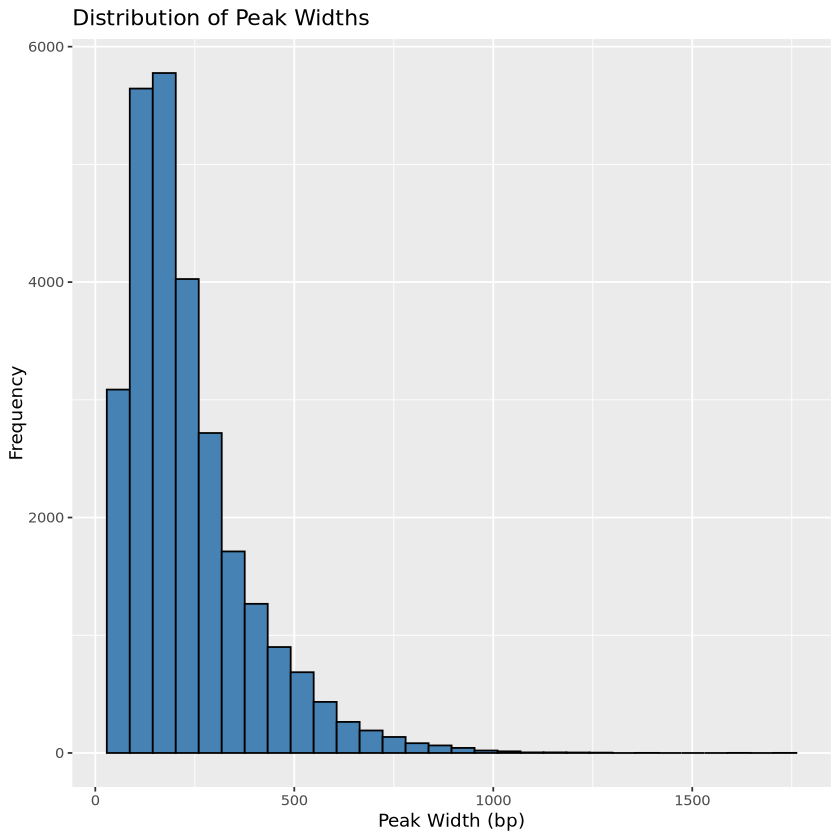

In [6]:
# Analyze peak widths
peak_widths <- width(peaks_gr)

# Plot the distribution of peak widths
library(ggplot2)
ggplot(data.frame(Peak_Width = peak_widths), aes(x = Peak_Width)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black") +
    labs(title = "Distribution of Peak Widths", x = "Peak Width (bp)", y = "Frequency")


In [7]:
summary(peak_widths)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   74.0   124.0   192.0   233.6   295.0  1749.0 

In [8]:
# Assuming metadata is already loaded
# Metadata contains treatment information in the column 'treatment:ch1'
treatment_column <- "treatment:ch1"

# Identify control and treatment samples based on the treatment column
control_metadata <- metadata[metadata[[treatment_column]] == "PBS", ]
treatment_metadata <- metadata[metadata[[treatment_column]] == "cetuximab", ]

# Display a summary of the control and treatment samples
cat("Number of control samples:", nrow(control_metadata), "\n")
cat("Number of treatment samples:", nrow(treatment_metadata), "\n")


Number of control samples: 9 
Number of treatment samples: 9 


In [10]:
# Link GEO accession IDs to their file paths
control_metadata$file_path <- paste0("../data/processed/ATAC_Seq/peak_files/", control_metadata$geo_accession, "_", control_metadata$title, "_Peaks.broadPeak.gz")
treatment_metadata$file_path <- paste0("../data/processed/ATAC_Seq/peak_files/", treatment_metadata$geo_accession, "_", treatment_metadata$title, "_Peaks.broadPeak.gz")

# Print file paths for verification
cat("Control file paths:\n")
print(control_metadata$file_path)

cat("Treatment file paths:\n")
print(treatment_metadata$file_path)


Control file paths:
[1] "../data/processed/ATAC_Seq/peak_files/GSM4021916_SCC1PBS_replicate1_Peaks.broadPeak.gz" 
[2] "../data/processed/ATAC_Seq/peak_files/GSM4021917_SCC1PBS_replicate2_Peaks.broadPeak.gz" 
[3] "../data/processed/ATAC_Seq/peak_files/GSM4021918_SCC1PBS_replicate3_Peaks.broadPeak.gz" 
[4] "../data/processed/ATAC_Seq/peak_files/GSM4021922_SCC6PBS_replicate1_Peaks.broadPeak.gz" 
[5] "../data/processed/ATAC_Seq/peak_files/GSM4021923_SCC6PBS_replicate2_Peaks.broadPeak.gz" 
[6] "../data/processed/ATAC_Seq/peak_files/GSM4021924_SCC6PBS_replicate3_Peaks.broadPeak.gz" 
[7] "../data/processed/ATAC_Seq/peak_files/GSM4021928_SCC25PBS_replicate1_Peaks.broadPeak.gz"
[8] "../data/processed/ATAC_Seq/peak_files/GSM4021929_SCC25PBS_replicate2_Peaks.broadPeak.gz"
[9] "../data/processed/ATAC_Seq/peak_files/GSM4021930_SCC25PBS_replicate3_Peaks.broadPeak.gz"
Treatment file paths:
[1] "../data/processed/ATAC_Seq/peak_files/GSM4021913_SCC1CTX_replicate1_Peaks.broadPeak.gz" 
[2] "../data/proce

In [11]:
# List all files in the directory to confirm available filenames
peak_files_directory <- "../data/processed/ATAC_Seq/peak_files"
available_files <- list.files(path = peak_files_directory, full.names = TRUE)
cat("Available Files:\n")
print(available_files)


Available Files:
 [1] "../data/processed/ATAC_Seq/peak_files/GSM4021913_SCC1CTX1_Peaks.broadPeak.gz" 
 [2] "../data/processed/ATAC_Seq/peak_files/GSM4021914_SCC1CTX2_Peaks.broadPeak.gz" 
 [3] "../data/processed/ATAC_Seq/peak_files/GSM4021915_SCC1CTX3_Peaks.broadPeak.gz" 
 [4] "../data/processed/ATAC_Seq/peak_files/GSM4021916_SCC1PBS1_Peaks.broadPeak.gz" 
 [5] "../data/processed/ATAC_Seq/peak_files/GSM4021918_SCC1PBS3_Peaks.broadPeak.gz" 
 [6] "../data/processed/ATAC_Seq/peak_files/GSM4021919_SCC6CTX1_Peaks.broadPeak.gz" 
 [7] "../data/processed/ATAC_Seq/peak_files/GSM4021920_SCC6CTX2_Peaks.broadPeak.gz" 
 [8] "../data/processed/ATAC_Seq/peak_files/GSM4021921_SCC6CTX3_Peaks.broadPeak.gz" 
 [9] "../data/processed/ATAC_Seq/peak_files/GSM4021922_SCC6PBS1_Peaks.broadPeak.gz" 
[10] "../data/processed/ATAC_Seq/peak_files/GSM4021923_SCC6PBS2_Peaks.broadPeak.gz" 
[11] "../data/processed/ATAC_Seq/peak_files/GSM4021924_SCC6PBS3_Peaks.broadPeak.gz" 
[12] "../data/processed/ATAC_Seq/peak_files/GSM4

In [12]:
# Compare metadata file paths to the available files
cat("Control Metadata File Paths:\n")
print(control_metadata$file_path)

cat("Treatment Metadata File Paths:\n")
print(treatment_metadata$file_path)


Control Metadata File Paths:
[1] "../data/processed/ATAC_Seq/peak_files/GSM4021916_SCC1PBS_replicate1_Peaks.broadPeak.gz" 
[2] "../data/processed/ATAC_Seq/peak_files/GSM4021917_SCC1PBS_replicate2_Peaks.broadPeak.gz" 
[3] "../data/processed/ATAC_Seq/peak_files/GSM4021918_SCC1PBS_replicate3_Peaks.broadPeak.gz" 
[4] "../data/processed/ATAC_Seq/peak_files/GSM4021922_SCC6PBS_replicate1_Peaks.broadPeak.gz" 
[5] "../data/processed/ATAC_Seq/peak_files/GSM4021923_SCC6PBS_replicate2_Peaks.broadPeak.gz" 
[6] "../data/processed/ATAC_Seq/peak_files/GSM4021924_SCC6PBS_replicate3_Peaks.broadPeak.gz" 
[7] "../data/processed/ATAC_Seq/peak_files/GSM4021928_SCC25PBS_replicate1_Peaks.broadPeak.gz"
[8] "../data/processed/ATAC_Seq/peak_files/GSM4021929_SCC25PBS_replicate2_Peaks.broadPeak.gz"
[9] "../data/processed/ATAC_Seq/peak_files/GSM4021930_SCC25PBS_replicate3_Peaks.broadPeak.gz"
Treatment Metadata File Paths:
[1] "../data/processed/ATAC_Seq/peak_files/GSM4021913_SCC1CTX_replicate1_Peaks.broadPeak.gz" 


In [13]:
# Function to find the correct file path based on GEO accession ID
find_correct_path <- function(geo_accession) {
    matching_files <- available_files[grepl(geo_accession, available_files)]
    if (length(matching_files) > 0) {
        return(matching_files[1])
    } else {
        return(NA) # Return NA if no matching file is found
    }
}

# Update the metadata to include the correct file paths
control_metadata$file_path <- sapply(control_metadata$geo_accession, find_correct_path)
treatment_metadata$file_path <- sapply(treatment_metadata$geo_accession, find_correct_path)

# Remove rows with NA file paths (samples that are missing)
control_metadata <- control_metadata[!is.na(control_metadata$file_path), ]
treatment_metadata <- treatment_metadata[!is.na(treatment_metadata$file_path), ]

# Print the corrected file paths
cat("Corrected Control File Paths:\n")
print(control_metadata$file_path)

cat("Corrected Treatment File Paths:\n")
print(treatment_metadata$file_path)


Corrected Control File Paths:
[1] "../data/processed/ATAC_Seq/peak_files/GSM4021916_SCC1PBS1_Peaks.broadPeak.gz" 
[2] "../data/processed/ATAC_Seq/peak_files/GSM4021918_SCC1PBS3_Peaks.broadPeak.gz" 
[3] "../data/processed/ATAC_Seq/peak_files/GSM4021922_SCC6PBS1_Peaks.broadPeak.gz" 
[4] "../data/processed/ATAC_Seq/peak_files/GSM4021923_SCC6PBS2_Peaks.broadPeak.gz" 
[5] "../data/processed/ATAC_Seq/peak_files/GSM4021924_SCC6PBS3_Peaks.broadPeak.gz" 
[6] "../data/processed/ATAC_Seq/peak_files/GSM4021928_SCC25PBS1_Peaks.broadPeak.gz"
[7] "../data/processed/ATAC_Seq/peak_files/GSM4021929_SCC25PBS2_Peaks.broadPeak.gz"
[8] "../data/processed/ATAC_Seq/peak_files/GSM4021930_SCC25PBS3_Peaks.broadPeak.gz"
Corrected Treatment File Paths:
[1] "../data/processed/ATAC_Seq/peak_files/GSM4021913_SCC1CTX1_Peaks.broadPeak.gz" 
[2] "../data/processed/ATAC_Seq/peak_files/GSM4021914_SCC1CTX2_Peaks.broadPeak.gz" 
[3] "../data/processed/ATAC_Seq/peak_files/GSM4021915_SCC1CTX3_Peaks.broadPeak.gz" 
[4] "../data/p

In [14]:
library("rtracklayer")
library("GenomicRanges")

# Function to load broadPeak files using rtracklayer's import function
load_broadPeak <- function(file_path) {
    import(file_path, format = "BED") # broadPeak is essentially a BED-like format
}

# Load all control and treatment peak files with the corrected paths
control_granges_list <- lapply(control_metadata$file_path, load_broadPeak)
treatment_granges_list <- lapply(treatment_metadata$file_path, load_broadPeak)

# Combine all control and all treatment peaks respectively
combined_control_gr <- reduce(do.call(c, control_granges_list))
combined_treatment_gr <- reduce(do.call(c, treatment_granges_list))

# Summary information
cat("Number of combined control peaks:", length(combined_control_gr), "\n")
cat("Number of combined treatment peaks:", length(combined_treatment_gr), "\n")


ERROR: Error in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, : scan() expected 'an integer', got '3.96522'


In [15]:
# Find overlapping peaks between combined treatment and control peaks
overlapping_peaks <- findOverlaps(combined_treatment_gr, combined_control_gr)

# Number of overlapping peaks
num_overlapping_peaks <- length(overlapping_peaks)
cat("Number of overlapping peaks between treatment and control:", num_overlapping_peaks, "\n")

# Find unique peaks in treatment and control
unique_treatment_peaks <- setdiff(combined_treatment_gr, combined_control_gr)
unique_control_peaks <- setdiff(combined_control_gr, combined_treatment_gr)

# Number of unique peaks
cat("Number of unique peaks in treatment samples:", length(unique_treatment_peaks), "\n")
cat("Number of unique peaks in control samples:", length(unique_control_peaks), "\n")


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'query' in selecting a method for function 'findOverlaps': object 'combined_treatment_gr' not found


In [16]:

# Load VennDiagram package for visualization
library(VennDiagram)

# Create a Venn diagram
venn.plot <- draw.pairwise.venn(
    area1 = length(combined_treatment_gr),
    area2 = length(combined_control_gr),
    cross.area = num_overlapping_peaks,
    category = c("Treatment", "Control"),
    fill = c("red", "blue"),
    alpha = 0.5,
    lty = "blank",
    cex = 1.5,
    cat.cex = 1.5,
    cat.pos = c(-20, 20)
)

grid.draw(venn.plot)


ERROR: Error in library(VennDiagram): there is no package called 'VennDiagram'


In [19]:
# Load the ChIPseeker library for annotation
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)

# Load TxDb for human genome annotations
txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene

# Annotate the overlapping peaks
overlapping_annotation <- annotatePeak(combined_treatment_gr[overlapping_peaks], TxDb = txdb)
cat("Annotation of overlapping peaks:\n")
print(head(as.data.frame(overlapping_annotation)))

# Annotate unique treatment peaks
unique_treatment_annotation <- annotatePeak(unique_treatment_peaks, TxDb = txdb)
cat("Annotation of unique treatment peaks:\n")
print(head(as.data.frame(unique_treatment_annotation)))

# Annotate unique control peaks
unique_control_annotation <- annotatePeak(unique_control_peaks, TxDb = txdb)
cat("Annotation of unique control peaks:\n")
print(head(as.data.frame(unique_control_annotation)))


ERROR: Error in library(ChIPseeker): there is no package called 'ChIPseeker'
